In [1]:
import matplotlib.pyplot as plt
import time

In [2]:
from common_functions import *

2022-12-05 15:53:24.076297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 15:53:24.794952: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 15:53:24.795009: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-05 15:53:24.795016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [15]:
# codebook = np.load('transformed_data/codebook.npy')
C = np.load('transformed_data/C.npy')
Cv = np.load('transformed_data/Cv.npy')
# L = np.load('transformed_data/L.npy')
# Lv = np.load('transformed_data/Lv.npy')
_, y, _, yv = load_mini_speech_commands()

# X, y, Xv, yv = load_mini_speech_commands()
# N_train = np.shape(X)[0]
# N_test = np.shape(Xv)[0]
# from sklearn.cluster import MiniBatchKMeans

# kmeans = MiniBatchKMeans(n_clusters=16)
# for Xi in X:
#     v = np.reshape(im2col(Xi),(64*64,4))
#     kmeans.partial_fit(v)
# codebook = kmeans.cluster_centers_
# np.save('transformed_data/codebook',codebook)

# # Encode
# C = np.zeros((N_train,64,64,4),dtype='int8')
# Cv = np.zeros((N_test,64,64,4),dtype='int8')
# for idx in range(N_train):
#     C[idx] = 2*VQ_encode_STFT(X[idx],codebook)-1
# for idx in range(N_test):
#     Cv[idx] = 2*VQ_encode_STFT(Xv[idx],codebook)-1
# np.save('transformed_data/C',C)
# np.save('transformed_data/Cv',Cv)

# # Decode
# L = np.zeros(np.shape(X))
# Lv = np.zeros(np.shape(Xv))
# for idx in range(N_train):
#     L[idx] = VQ_decode_STFT(((C[idx]+1)//2).astype('int8'),codebook)
# for idx in range(N_test):
#     Lv[idx] = VQ_decode_STFT(((Cv[idx]+1)//2).astype('int8'),codebook)
# np.save('transformed_data/L',L)
# np.save('transformed_data/Lv',Lv)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


In [57]:
model = models.Sequential([
    layers.Input(shape=(64,64,4)),
    layers.BatchNormalization(),
    lq.layers.QuantConv2D(32, 3, activation='relu',input_quantizer="ste_sign"),
    layers.MaxPooling2D(pool_size=(2,2)),
    lq.layers.QuantConv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    lq.layers.QuantDense(128, activation='relu'),
    lq.layers.QuantDense(8),
])
lq.models.summary(model)

+sequential_17 stats--------------------------------------------------------------------+
| Layer                   Input prec.           Outputs  # 32-bit   Memory  32-bit MACs |
|                               (bit)                         x 1     (kB)              |
+---------------------------------------------------------------------------------------+
| batch_normalization_20            -   (-1, 64, 64, 4)         8     0.03            0 |
| quant_conv2d_19                   1  (-1, 62, 62, 32)      1184     4.62      4428288 |
| max_pooling2d_24                  -  (-1, 31, 31, 32)         0        0            0 |
| quant_conv2d_20                   -  (-1, 29, 29, 64)     18496    72.25     15501312 |
| max_pooling2d_25                  -  (-1, 14, 14, 64)         0        0            0 |
| flatten_17                        -       (-1, 12544)         0        0            0 |
| quant_dense_32                    -         (-1, 128)   1605760  6272.50      1605632 |
| quant_de

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [59]:
train_acc = [];
test_acc = [];
elapsed_time = [];

50/50 [==============================] - 0s 3ms/step - loss: 1.3831 - accuracy: 0.7225


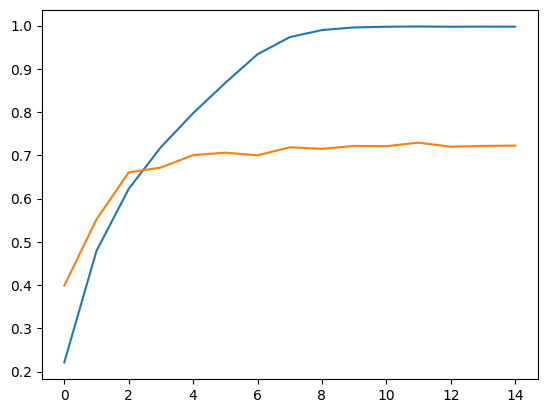

In [60]:
for i_iter in range(15):
    t = time.process_time()
    train_history = model.fit(x=C, y=y, epochs=1, batch_size=64);
    elapsed_time.append(time.process_time()-t)
    _, test_acc_i = model.evaluate(x=Cv, y=yv)
    train_acc.append(train_history.history['accuracy'][0])
    test_acc.append(test_acc_i)
plt.plot(np.vstack(train_acc))
plt.plot(np.vstack(test_acc))

In [62]:
print(np.median(elapsed_time), "seconds/iteration")
print(np.median(test_acc[-5:]), "test accuracy")

1.105548300999999 seconds/iteration
0.721875011920929 test accuracy
